## Sea Animals Image Dataset
https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste

## 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 라이브러리

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import recall_score, f1_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## 함수 정의

In [ ]:
# 레이블이 있는 데이터 경로 생성
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# 레이블이 있는 데이터 경로를 하나의 데이터 프레임으로 연결
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# 학습, 검증, 테스트 데이터로 나누기
def split_data(data_dir):
    # 학습
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # 검증및 테스트 데이터
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df


def preprocess_image(image_path):
    image = load_img(image_path, target_size=img_shape)
    image = img_to_array(image) / 255.0  # 이미지를 0~1 사이의 값으로 정규화
    return image

def data_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for index in indices:
            image = preprocess_image(image_paths[index])
            label = labels[index]
            batch_images.append(image)
            batch_labels.append(label)
        yield np.array(batch_images), np.array(batch_labels)


# 데이터 확대를 위해 이미지 데이터 생성기에서 사용, 이미지를 가져와서 다시 반환
def scalar(img):
    return img

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

## 데이터 준비

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝의 이해/Sea Animals'
# 데이터셋 나누기
train_df, valid_df, test_df = split_data(dataset_path)

Found 10968 validated image filenames belonging to 23 classes.
Found 1371 validated image filenames belonging to 23 classes.
Found 1372 validated image filenames belonging to 23 classes.


In [ ]:
# 이미지 전처리 및 데이터 제너레이터 설정
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 40

In [ ]:
# 테스트 데이터 배치 크기에 대한 사용자 지정 기능을 사용하거나 일반 배치 크기를 사용
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)
 # 맞춤 test_batch_size를 사용하고 shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= False, batch_size= test_batch_size)

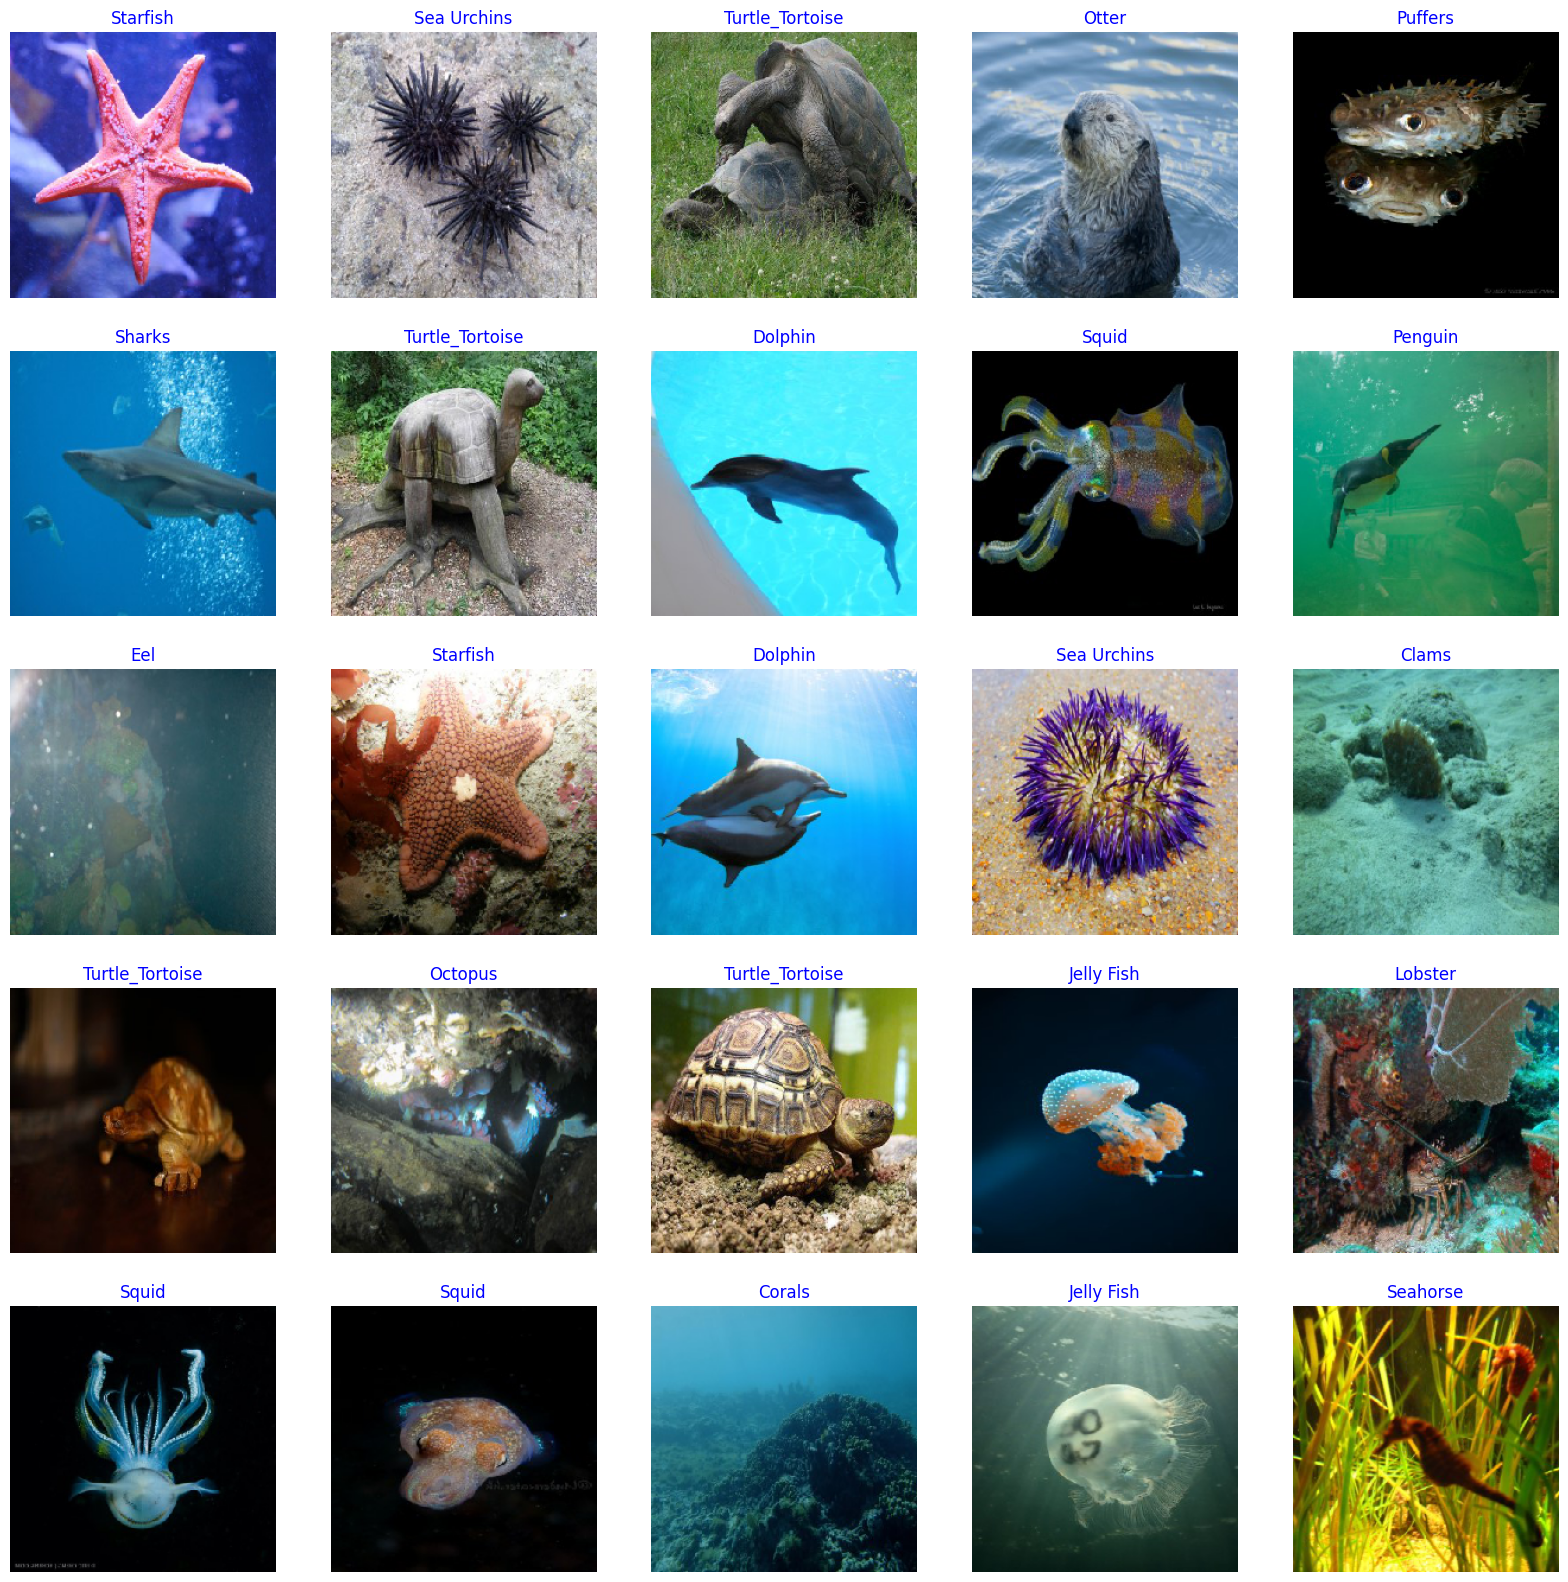

In [ ]:
show_images(train_gen)

## 모델 정의

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=img_shape)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=23, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
class_count = len(list(train_gen.class_indices.keys()))
class_count

23

## 모델 컴파일

In [ ]:
# 모델 컴파일
model = Model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## 모델 학습

In [ ]:
history = model.fit(x= train_gen, epochs= 10, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
275/275 [==============================] - 3294s 12s/step - loss: 39.9342 - accuracy: 0.1194 - val_loss: 3.0974 - val_accuracy: 0.1327
Epoch 2/10
275/275 [==============================] - 54s 196ms/step - loss: 2.9729 - accuracy: 0.1545 - val_loss: 2.9962 - val_accuracy: 0.1357
Epoch 3/10
275/275 [==============================] - 53s 194ms/step - loss: 2.7606 - accuracy: 0.1965 - val_loss: 3.0020 - val_accuracy: 0.1692
Epoch 4/10
275/275 [==============================] - 54s 197ms/step - loss: 2.4527 - accuracy: 0.3007 - val_loss: 3.0689 - val_accuracy: 0.1699
Epoch 5/10
275/275 [==============================] - 53s 193ms/step - loss: 2.1023 - accuracy: 0.4103 - val_loss: 3.3716 - val_accuracy: 0.1736
Epoch 6/10
275/275 [==============================] - 57s 206ms/step - loss: 1.7891 - accuracy: 0.5045 - val_loss: 3.5231 - val_accuracy: 0.1772
Epoch 7/10
275/275 [==============================] - 55s 201ms/step - loss: 1.4500 - accuracy: 0.5981 - val_loss: 3.8147 - val_a

## 모델 시각화

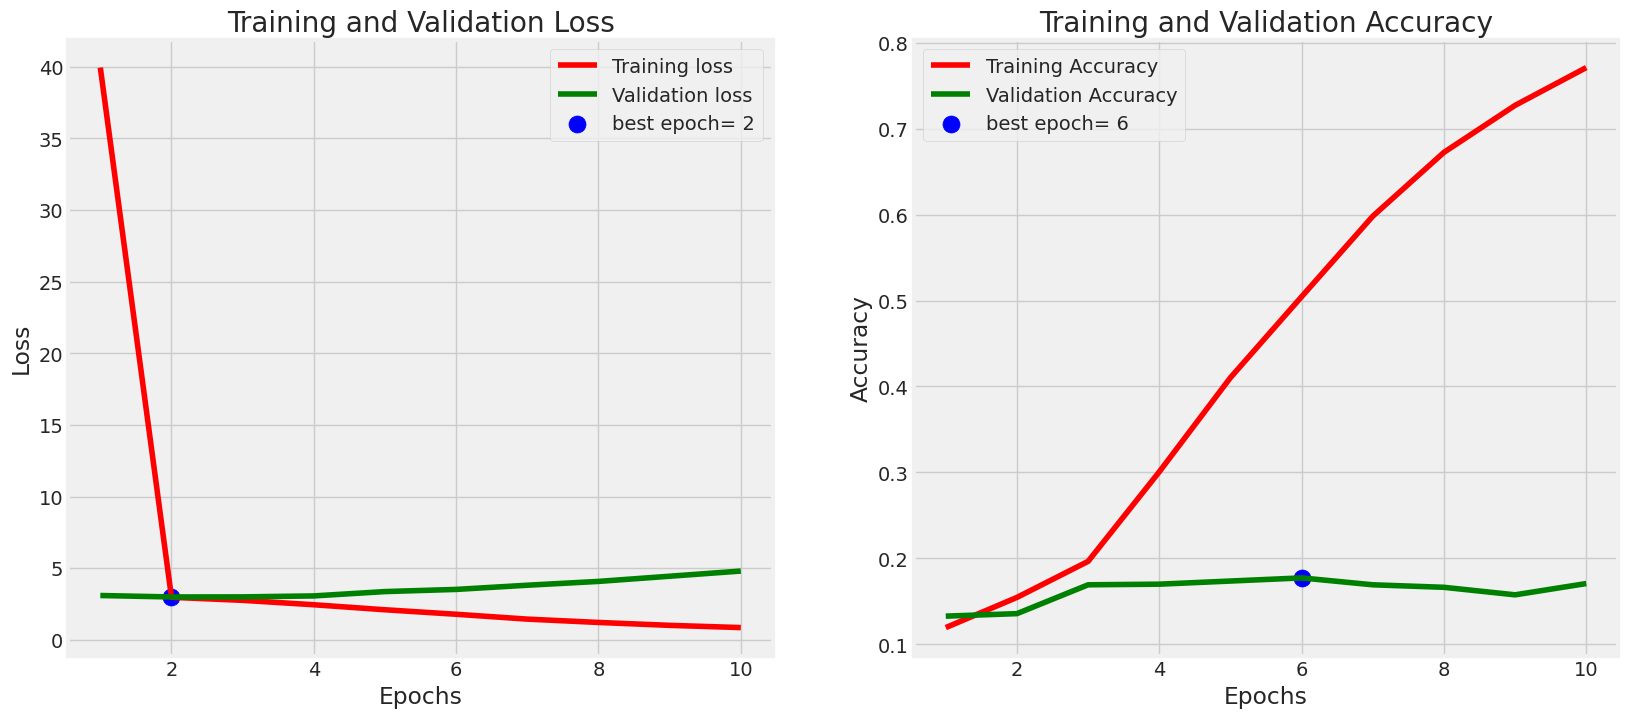

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

28/28 [==============================] - 339s 13s/step - loss: 4.7183 - accuracy: 0.1669
Train Loss:  0.7696205973625183
Train Accuracy:  0.7946428656578064
--------------------
Validation Loss:  4.749619960784912
Validation Accuracy:  0.17232142388820648
--------------------
Test Loss:  4.718286037445068
Test Accuracy:  0.1669096201658249


In [ ]:
# 모델 예측
y_true = []
y_pred = []

# Train data 예측
for batch in train_gen:
    x, y = batch
    y_true.extend(np.argmax(y, axis=1))
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))

train_recall = recall_score(y_true, y_pred, average='macro')
train_f1 = f1_score(y_true, y_pred, average='macro')

# Validation data 예측
y_true = []
y_pred = []

for batch in valid_gen:
    x, y = batch
    y_true.extend(np.argmax(y, axis=1))
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))

valid_recall = recall_score(y_true, y_pred, average='macro')
valid_f1 = f1_score(y_true, y_pred, average='macro')

# Test data 예측
y_true = []
y_pred = []

for batch in test_gen:
    x, y = batch
    y_true.extend(np.argmax(y, axis=1))
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))

test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

print("Train Recall: ", train_recall)
print("Train F1 Score: ", train_f1)
print('-' * 20)
print("Validation Recall: ", valid_recall)
print("Validation F1 Score: ", valid_f1)
print('-' * 20)
print("Test Recall: ", test_recall)
print("Test F1 Score: ", test_f1)

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[21 21 12 ... 22 21 14]
